# 1. Descripción del problema o formulación de una pregunta de interés. 

En el campo de las finanzas, el pronóstico del precio o del rendimiento de un activo financiero es fundamental. Predecir el valor de estos activos es crucial para la gestión de riesgos, el trading algorítmico y la evaluación del desempeño de estrategias de inversión en portafolios basados en pronósticos. La incertidumbre inherente a estos activos representa un riesgo significativo para quienes toman decisiones de compra y venta. La teoría de los mercados eficientes sugiere que los precios de los activos no son predecibles, lo que implica un desafío adicional para los analistas financieros.

Tradicionalmente, se han utilizado modelos como el ARIMA para realizar pronósticos, que aunque a veces ofrecen resultados aceptables, requieren suposiciones fuertes para su construcción, como la estacionariedad. Sin embargo, el análisis empírico ha demostrado que las series financieras a menudo no cumplen con este supuesto, incluso cuando se transforman en rendimientos mediante diferenciación logarítmica. Esto se debe al fenómeno de la agrupación de volatilidad (volatility clustering), que causa heterocedasticidad y, por ende, no estacionariedad en la varianza.

Para abordar estos problemas, se han utilizado modelos estadísticos paramétricos como los CHARMA. No obstante, en este contexto se propone el uso de redes neuronales para mejorar los pronósticos. Estas técnicas pueden reducir la complejidad del problema al no depender de suposiciones tan estrictas como las que requieren los métodos tradicionales.

En este caso se pronosticará el precio de la acción de AAPL, teniendo en cuenta el precio de cierre ajustado. El uso del precio de cierre ajustado es el más adecuado debido a que refleja con mayor precisión el valor real de la acción, ya que tiene en cuenta eventos corporativos como dividendos, splits y otras acciones corporativas que pueden afectar el precio de las acciones. Esto garantiza que los pronósticos y las estrategias de inversión basadas en estos datos sean más precisos y representativos de las condiciones reales del mercado. Además, el precio de cierre ajustado proporciona una serie de tiempo continua y coherente, lo que facilita el análisis y la modelización de las tendencias del mercado a lo largo del tiempo

# 2. Exploración de los datos para su entendimiento.

In [67]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [68]:
ticker_symbol = 'AAPL'
data = yf.download(ticker_symbol, start='2013-01-01', end='2024-05-18')
print(data.head())

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2013-01-02  19.779285  19.821428  19.343929  19.608213  16.725044  560518000
2013-01-03  19.567142  19.631071  19.321428  19.360714  16.513933  352965200
2013-01-04  19.177500  19.236786  18.779642  18.821428  16.053942  594333600
2013-01-07  18.642857  18.903570  18.400000  18.710714  15.959514  484156400
2013-01-08  18.900356  18.996071  18.616072  18.761070  16.002462  458707200


Inicialmente, vemos como el precio de cierre ajustado de AAPL es bastante volátil. Cuenta con una tendencia creciente, sobre todo a partir del año 2020, época en la que diferentes bienes de tecnología aceleraron su demanda debido a las condiciones particulares. Así mismo, se observa que en los dos últimos años, esta tendencia creciente se aplana un poco.

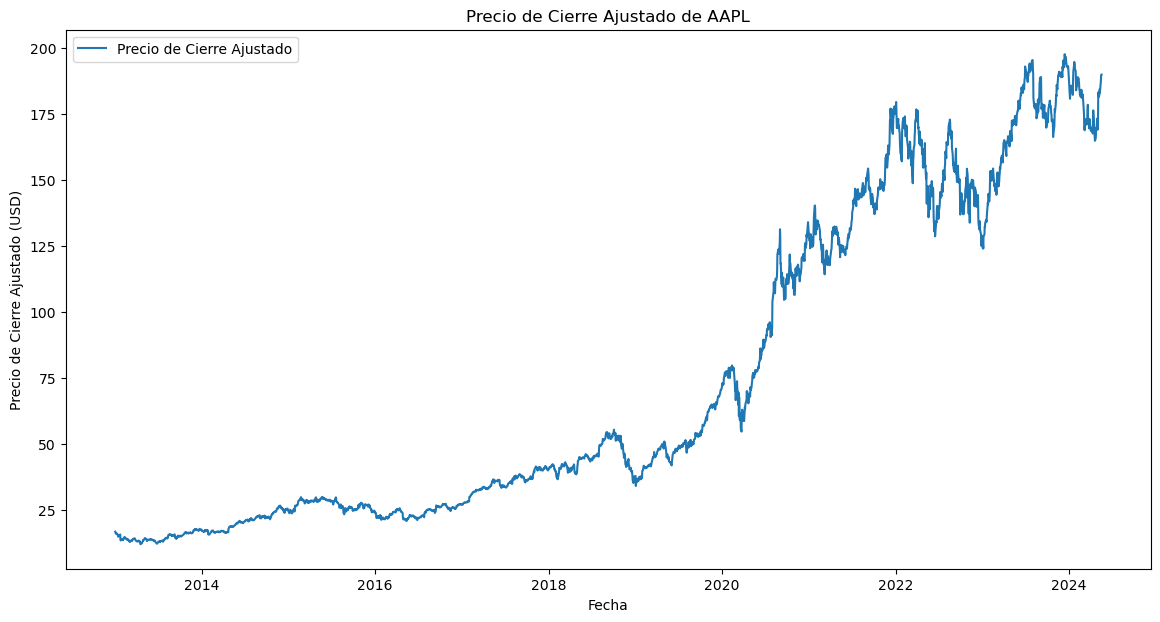

In [69]:
plt.figure(figsize=(14, 7))
plt.plot(data['Adj Close'], label='Precio de Cierre Ajustado')
plt.title('Precio de Cierre Ajustado de AAPL')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre Ajustado (USD)')
plt.legend()
plt.show()

Por otra parte, se calculan los rendimientos del precio de AAPL y se observa su distribución. A pesar de que pareciera una distribución normal, los rendimientos financieros tienden a ajustarse más a una distribución cauchy (también conocida como distribución de Cauchy-Lorentz) que a una distribución normal. La distribución cauchy es una distribución de cola pesada, lo que significa que tiene colas más largas en comparación con la distribución normal, lo que indica una mayor probabilidad de ocurrencia de eventos extremos o inesperados. Esto refleja la naturaleza volátil y no lineal de los mercados financieros, donde los movimientos bruscos y los eventos extremos son relativamente comunes.

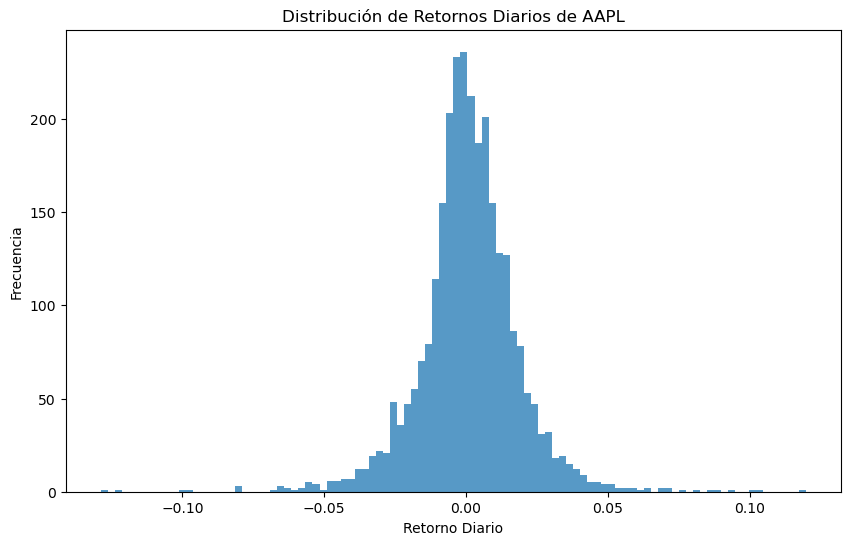

In [70]:
data['Return'] = data['Adj Close'].pct_change()

plt.figure(figsize=(10, 6))
plt.hist(data['Return'].dropna(), bins=100, alpha=0.75)
plt.title('Distribución de Retornos Diarios de AAPL')
plt.xlabel('Retorno Diario')
plt.ylabel('Frecuencia')
plt.show()

Por otra parte, esta serie de rendimientos, si bien parece ser estacionaria y exhibir una tendencia a moverse alrededor de una media constante, presenta períodos de volatilidad cambiante. Al observar la volatilidad anualizada, se confirma esta observación, ya que se aprecia una variabilidad en la magnitud de las fluctuaciones a lo largo del tiempo. Este fenómeno sugiere que, si bien la serie puede mantener cierta estabilidad en su tendencia general, los períodos de mayor o menor volatilidad pueden influir significativamente en el riesgo y la incertidumbre asociados con los movimientos de precios.

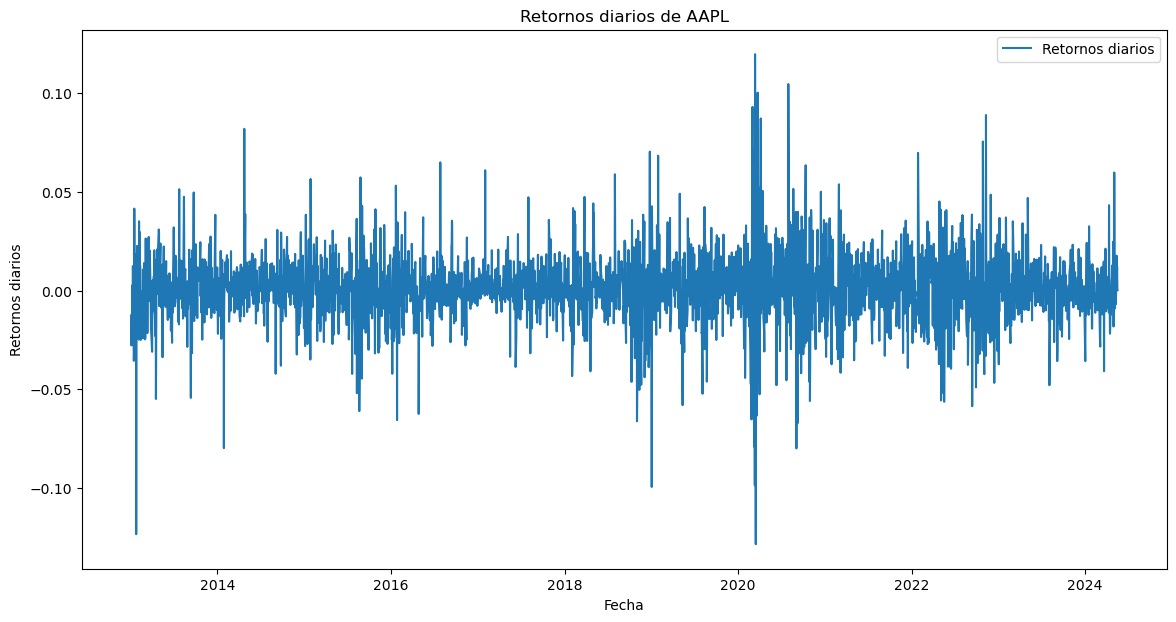

In [71]:
plt.figure(figsize=(14, 7))
plt.plot(data['Return'], label='Retornos diarios')
plt.title('Retornos diarios de AAPL')
plt.xlabel('Fecha')
plt.ylabel('Retornos diarios')
plt.legend()
plt.show()

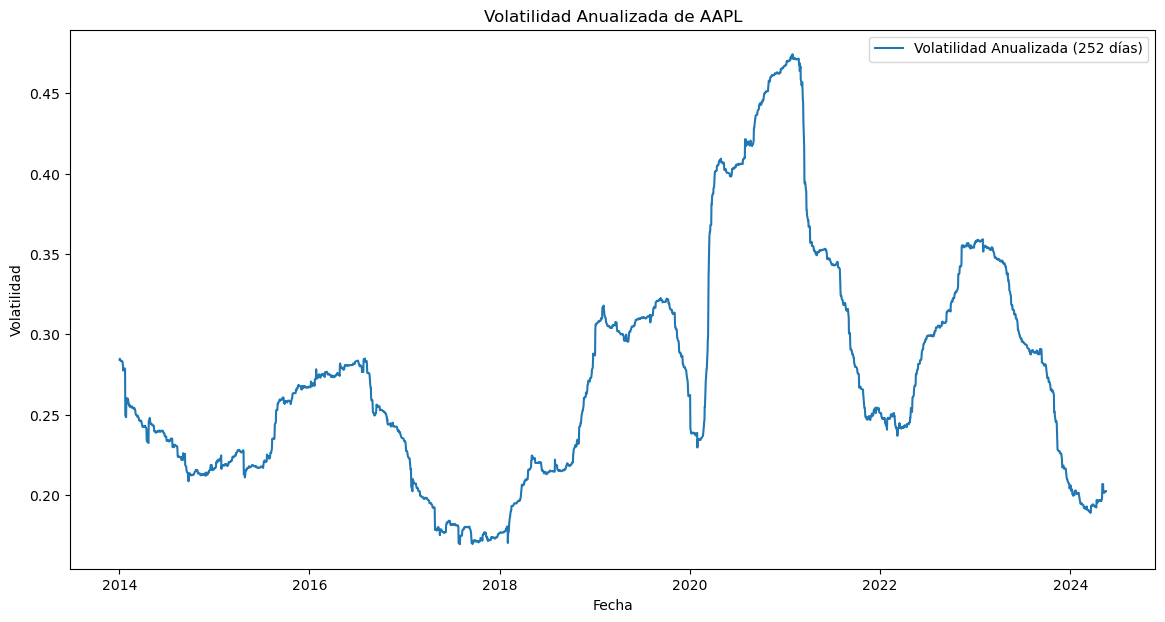

In [73]:
rolling_volatility = data['Return'].rolling(window=252).std() * (252**0.5)  # Annualizada

plt.figure(figsize=(14, 7))
plt.plot(rolling_volatility, label='Volatilidad Anualizada (252 días)')
plt.title('Volatilidad Anualizada de AAPL')
plt.xlabel('Fecha')
plt.ylabel('Volatilidad')
plt.legend()
plt.show()

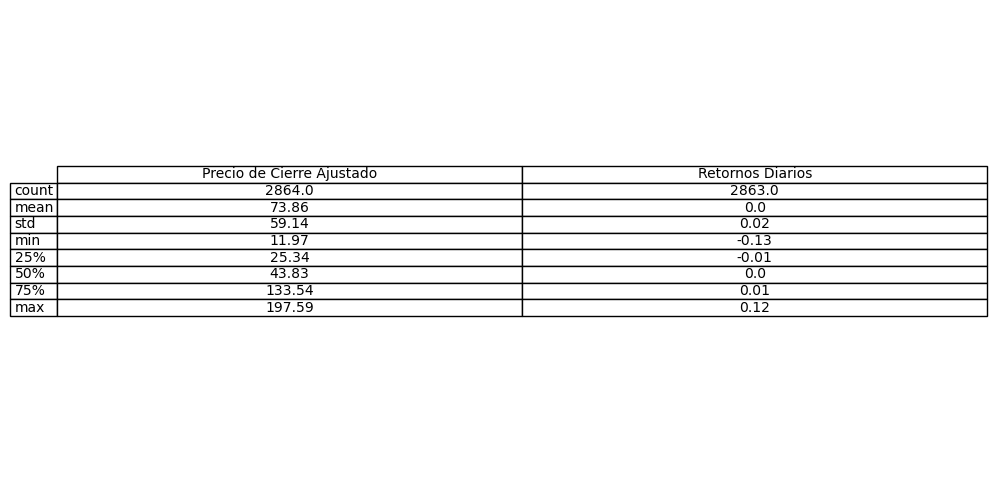

In [74]:
summary = {
    'Precio de Cierre Ajustado': data['Adj Close'].describe(),
    'Retornos Diarios': data['Return'].describe()
}

summary_df = pd.DataFrame(summary).round(2)

fig, ax = plt.subplots(figsize=(12, 6))  # Ajusta el tamaño según sea necesario
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=summary_df.values, colLabels=summary_df.columns, rowLabels=summary_df.index, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
plt.show()

# 3. Preparación de los datos para poder utilizarlos como entrada en modelos de deep learning. 

Primero, el código selecciona la columna 'Adj Close' de los datos originales y la normaliza utilizando el escalador MinMaxScaler. La normalización es una práctica común en el procesamiento de datos para redes neuronales, ya que ayuda a mantener todas las características en una escala similar, lo que puede mejorar la convergencia del modelo y su capacidad para capturar patrones en los datos.

Luego, los datos normalizados se dividen en conjuntos de entrenamiento y prueba. El 80% de los datos se utilizan para entrenar el modelo, mientras que el 20% restante se utiliza para evaluar su rendimiento.

La función create_dataset se define para convertir los datos en una estructura adecuada para el entrenamiento de la red neuronal. Esta función crea secuencias de datos de entrada (X) y salidas esperadas (y) con un tamaño de paso especificado. Por ejemplo, si time_step es 60, la red neuronal utilizará los últimos 60 días de datos para predecir el siguiente día.

Finalmente, las secuencias de datos se reformatean para que tengan la forma requerida por la red neuronal. En este caso, se agregó una dimensión adicional al final para indicar que solo hay una característica en cada punto de datos.

In [91]:
data = data[['Adj Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size, :], scaled_data[train_size:len(scaled_data), :]

def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        X.append(a)
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


# 4. Análisis sobre la selección del modelo de deep learning apropiado y la estrategia de estimación y calibración. 


El modelo LSTM (Long Short-Term Memory) es especialmente apropiado para el pronóstico de series temporales debido a su capacidad para capturar y aprender dependencias a largo plazo en los datos. Las series temporales, como los precios de acciones, contienen patrones y tendencias que se desarrollan a lo largo del tiempo, y la habilidad de las LSTM para retener información relevante de períodos anteriores es crucial para realizar predicciones precisas. A diferencia de las redes neuronales tradicionales que pueden tener dificultades para manejar las dependencias de largo plazo debido al problema del desvanecimiento del gradiente, las LSTM están diseñadas con una arquitectura de celdas de memoria que pueden recordar información durante largos intervalos, lo cual es fundamental para identificar y aprovechar patrones temporales complejos.

En comparación con otras técnicas de pronóstico, como los modelos ARIMA o las redes neuronales feedforward, las LSTM presentan varias ventajas. Primero, las LSTM no requieren una preprocesamiento extenso de los datos, como la diferenciación necesaria en los modelos ARIMA para lograr la estacionariedad. Segundo, las LSTM son más flexibles al manejar datos no lineales y pueden captar interacciones complejas entre variables temporales sin la necesidad de especificar explícitamente estas relaciones. Además, las LSTM pueden integrarse fácilmente en arquitecturas más complejas de deep learning, permitiendo la combinación de datos de series temporales con otras fuentes de datos (por ejemplo, texto o imágenes) para mejorar la precisión del pronóstoc

En esta implementación, hemos utilizado una estrategia de calibración de hiperparámetros que combina la búsqueda aleatoria (Random Search) y la validación cruzada con división temporal (Time Series Split), asegurando la reproducibilidad mediante el establecimiento de una semilla fija. El proceso comenzó dividiendo los datos de precios ajustados de las acciones de Apple en conjuntos de entrenamiento y prueba. Posteriormente, se normalizaron los datos y se crearon ventanas temporales de 60 días. Para calibrar los hiperparámetros del modelo LSTM, se definió una cuadrícula que incluye el número de unidades LSTM, capas, tasas de dropout, tamaños de lote, épocas y dos optimizadores (Adam y RMSprop). Utilizando RandomizedSearchCV con 10 iteraciones y TimeSeriesSplit con 5 divisiones, se exploraron diversas combinaciones de hiperparámetros. Esta metodología no solo optimiza la selección de hiperparámetros, sino que también garantiza que los resultados sean reproducibles y robustos frente a variaciones en los datos de entrada, mejorando así la precisión y la generalización del modelo entrenado.

# 5. Desarrollo y calibración de modelos. 

A continuación, se implementa el código para la estrategia de calibración definida en el punto anterior.

In [28]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
import random

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

def create_model(units=50, layers=1, dropout_rate=0.2, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units, return_sequences=(layers > 1), input_shape=(time_step, 1)))
    for _ in range(layers - 1):
        model.add(LSTM(units, return_sequences=True))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Envolver el modelo para usarlo con scikit-learn
model = KerasRegressor(build_fn=create_model, verbose=1)

# Definir la cuadrícula de hiperparámetros
param_grid = {
    'units': [50, 100, 150],
    'layers': [1, 2, 3],
    'dropout_rate': [0.2, 0.3, 0.5],
    'batch_size': [16, 32, 64],
    'epochs': [10, 20, 30],
    'optimizer': ['adam', 'rmsprop']
}

# Utilizar TimeSeriesSplit para la validación cruzada
tscv = TimeSeriesSplit(n_splits=5)

# Usar RandomizedSearchCV para encontrar los mejores hiperparámetros
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=tscv, random_state=seed, n_jobs=-1)

# Ajustar el modelo y encontrar los mejores hiperparámetros
random_search_result = random_search.fit(X_train, y_train)

# Imprimir los mejores hiperparámetros
print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))


C:\Users\Juan Felipe\AppData\Local\Temp\ipykernel_15584\3436105634.py:28: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=1)


Epoch 1/30
35/35 [==============================] - 2s 22ms/step - loss: 0.0079
Epoch 2/30
35/35 [==============================] - 1s 22ms/step - loss: 0.0011
Epoch 3/30
35/35 [==============================] - 1s 25ms/step - loss: 7.4638e-04
Epoch 4/30
35/35 [==============================] - 1s 25ms/step - loss: 7.3580e-04
Epoch 5/30
35/35 [==============================] - 1s 25ms/step - loss: 5.2019e-04
Epoch 6/30
35/35 [==============================] - 1s 25ms/step - loss: 5.7448e-04
Epoch 7/30
35/35 [==============================] - 1s 24ms/step - loss: 4.0673e-04
Epoch 8/30
35/35 [==============================] - 1s 25ms/step - loss: 4.1921e-04
Epoch 9/30
35/35 [==============================] - 1s 25ms/step - loss: 3.4049e-04
Epoch 10/30
35/35 [==============================] - 1s 24ms/step - loss: 3.8912e-04
Epoch 11/30
35/35 [==============================] - 1s 28ms/step - loss: 3.0667e-04
Epoch 12/30
35/35 [==============================] - 1s 31ms/step - loss: 3.0012e-

Teniendo en cuenta los hiperparámetros obtenidos de este proceso de calibración, se procede a ajustar el modelo, pero esta vez con un numero mayor de épocas. La red consta de una capa LSTM con 100 unidades, lo que significa que hay 100 células de memoria en esta capa. Esto le permite capturar y aprender patrones complejos en series temporales, como las fluctuaciones de precios en el mercado de valores.

La arquitectura también incluye una capa de abandono (dropout) con una tasa del 20%. El abandono es una técnica de regularización que ayuda a prevenir el sobreajuste al desactivar aleatoriamente una fracción de las unidades de la capa durante el entrenamiento, lo que obliga a la red a aprender representaciones más robustas y generalizables de los datos.

Para optimizar los pesos de la red, se utiliza el optimizador RMSprop, que es un algoritmo de optimización popular para redes neuronales recurrentes. RMSprop adapta la tasa de aprendizaje de forma individual para cada parámetro, lo que puede ayudar a acelerar la convergencia del entrenamiento y a mejorar el rendimiento de la red.

Además, se usa ModelCheckpoint para guardar el modelo con el mejor rendimiento en función de la pérdida de validación. Esto asegura que el modelo guardado sea el que tenga la pérdida más baja en el conjunto de datos de validación, lo que ayuda a prevenir el sobreajuste y a garantizar que se conserve el mejor modelo entrenado.

In [76]:
from keras.callbacks import ModelCheckpoint

model = create_model(units=100, layers=1, dropout_rate=0.2, optimizer='rmsprop')
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=64, verbose=1, callbacks=[checkpoint])

Epoch 1/200
35/35 [==============================] - 3s 35ms/step - loss: 0.0075 - val_loss: 0.0069
Epoch 2/200
35/35 [==============================] - 1s 28ms/step - loss: 8.8379e-04 - val_loss: 0.0019
Epoch 3/200
35/35 [==============================] - 1s 27ms/step - loss: 8.0429e-04 - val_loss: 0.0030
Epoch 4/200
35/35 [==============================] - 1s 28ms/step - loss: 6.8020e-04 - val_loss: 0.0011
Epoch 5/200
35/35 [==============================] - 1s 26ms/step - loss: 4.7085e-04 - val_loss: 0.0012
Epoch 6/200
35/35 [==============================] - 1s 27ms/step - loss: 4.7246e-04 - val_loss: 9.1827e-04
Epoch 7/200
35/35 [==============================] - 1s 28ms/step - loss: 3.9748e-04 - val_loss: 0.0014
Epoch 8/200
35/35 [==============================] - 1s 28ms/step - loss: 3.5851e-04 - val_loss: 0.0014
Epoch 9/200
35/35 [==============================] - 1s 26ms/step - loss: 2.9836e-04 - val_loss: 0.0019
Epoch 10/200
35/35 [==============================] - 1s 28ms/st

# 6. Visualización de resultados.

El modelo ajustado exhibe una tendencia favorable en la disminución de la función de pérdida a medida que progresa el entrenamiento a través de múltiples épocas. Esta disminución indica que el modelo está aprendiendo de manera efectiva a partir de los datos y está mejorando su capacidad predictiva con el tiempo. Además, los valores de RMSE obtenidos, de 1.56 en la base de prueba y 3.24 en la base de entrenamiento, sugieren que el modelo generaliza bien a nuevos datos, ya que el error de predicción es bajo en relación con el rango de precios de la acción mencionado, alrededor de 187 dólares al día de hoy. Esto indica que el modelo tiene el potencial de ser útil en la predicción de los precios de esta acción, proporcionando estimaciones precisas y fiables que pueden ser valiosas para la toma de decisiones financieras. Adicionalmente, se muestra de forma gráfica el comportamiento de los valores reales y pronosticados y se alcanza a observar cómo el modelo captura de forma adecuada las tendencias y muchas de las variaciones en la serie.

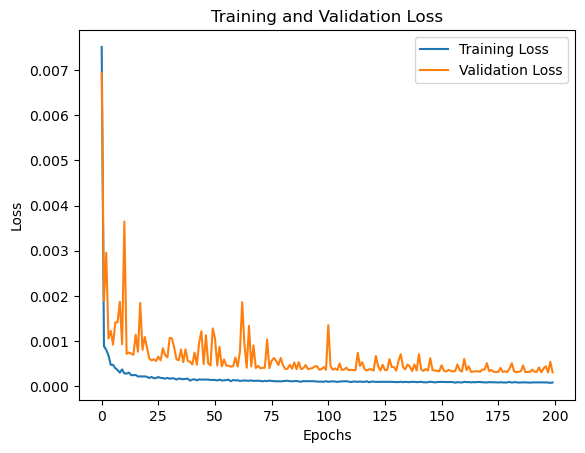

In [110]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear un gráfico de línea para mostrar cómo cambian las pérdidas en función de las épocas
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [108]:
# Se realizan predicciones
trainPredict = model.predict(X_train, batch_size=64)
testPredict = model.predict(X_test, batch_size=64)

# Se devuelve el escalado de las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
y_train_inv = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
y_test_inv = scaler.inverse_transform([y_test])

# Se calcula RMSE
trainScore = np.sqrt(mean_squared_error(y_train_inv[0], trainPredict[:,0]))
testScore = np.sqrt(mean_squared_error(y_test_inv[0], testPredict[:,0]))

print('Train Score: %.2f RMSE' % (trainScore))
print('Test Score: %.2f RMSE' % (testScore))


8/8 [==============================] - 0s 9ms/step
Train Score: 1.56 RMSE
Test Score: 3.24 RMSE


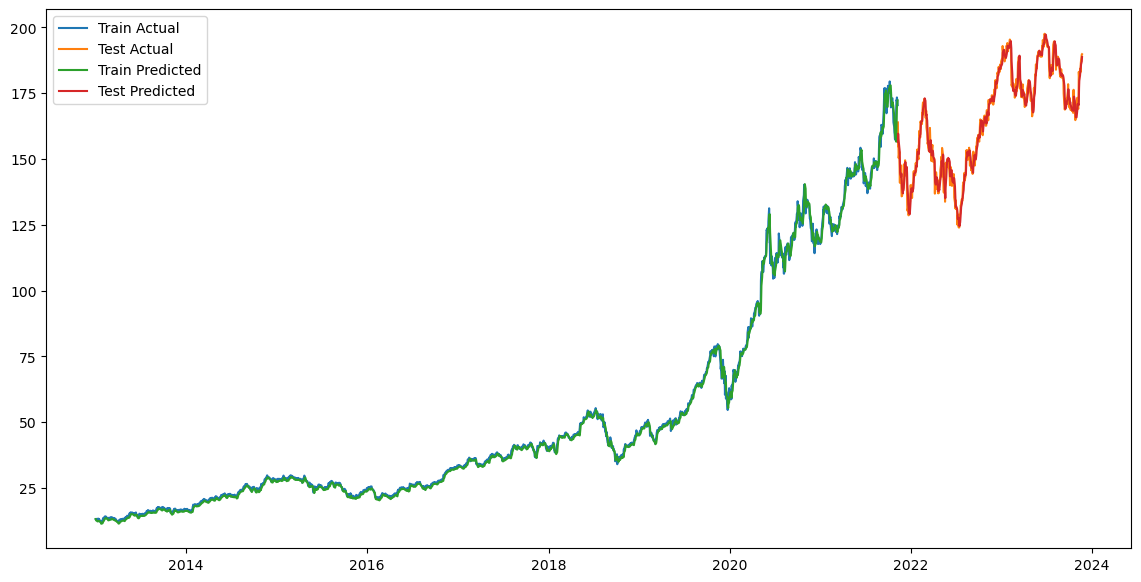

In [109]:
plt.figure(figsize=(14, 7))
plt.plot(data.index[:len(trainPredict)], y_train_inv.flatten(), label='Train Actual')
plt.plot(data.index[len(trainPredict):len(trainPredict) + len(testPredict)], y_test_inv.flatten(), label='Test Actual')
plt.plot(data.index[:len(trainPredict)], trainPredict.flatten(), label='Train Predicted')
plt.plot(data.index[len(trainPredict):len(trainPredict) + len(testPredict)], testPredict.flatten(), label='Test Predicted')
plt.legend()
plt.show()

# 7. Implementación y demostración de la utilidad de los resultados. 

A continuación se presentará una implementación con el fin de mostrar la utilidad del modelo de pronóstico. En este caso se utilizará para evaluar el desempeño de una estrategia de inversión basada en pronósticos. La estrategia simulada se fundamenta en la capacidad del modelo para predecir los movimientos futuros del mercado. Con un capital inicial de $1000, la estrategia se ejecuta de manera automatizada: si el modelo predice que el precio de cierre de las acciones será superior al precio actual, se compra; si la predicción indica un precio inferior, se venden todas las acciones. Este enfoque ilustra cómo los pronósticos pueden servir como guía para tomar decisiones de inversión informadas y oportunas. 

En el contexto específico de esta simulación, la estrategia arrojó un saldo final de $3862, destacando su capacidad para generar rendimientos positivos en el periodo evaluado. Es importante tener en cuenta que esta simulación no tiene en cuenta los costos de transacción, como comisiones por operación, ni otros factores que pueden afectar el rendimiento real de la estrategia. Sin embargo, se incorpora un ajuste al considerar el precio de cierre ajustado, que tiene en cuenta eventos como splits o repartición de dividendos, lo que proporciona una representación más precisa de los retornos potenciales.

In [111]:
initial_balance = 1000  # Dólares iniciales
balance = initial_balance
shares = 0  # Cantidad inicial de acciones
last_price = None  # Último precio registrado

for i in range(len(testPredict)):
    predicted_price = testPredict[i]
    
    if last_price is not None:
        if predicted_price > last_price:
            # Comprar acciones con todo el saldo disponible
            shares_to_buy = balance / testPredict[i]
            shares += shares_to_buy
            balance = 0
        elif predicted_price < last_price:
            # Vender todas las acciones
            balance += shares * testPredict[i]
            shares = 0
    
    last_price = predicted_price

# Calcular el valor final de la inversión
final_value = balance + (shares * testPredict[-1])

print("Valor final de la inversión:", final_value)


Valor final de la inversión: [3862.1282]
